# Extract Subject Matter of Documents Using NLP 
https://medium.com/@acrosson/extract-subject-matter-of-documents-using-nlp-e284c1c61824


https://github.com/acrosson/nlp/tree/master/subject_extraction


In [5]:
import pandas as pd

In [56]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\hag8665\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\treebank.zip.


True

In [44]:
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\hag8665\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping chunkers\maxent_ne_chunker.zip.


True

In [47]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hag8665\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

In [52]:
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\hag8665\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.


True

In [54]:
nltk.download('conll2000')

[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\hag8665\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\conll2000.zip.


True

In [50]:
from trigram_tagger import SubjectTrigramTagger
from bs4 import BeautifulSoup
import requests
import re
import pickle
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Noun Part of Speech Tags used by NLTK
# More can be found here
# http://www.winwaed.com/blog/2011/11/08/part-of-speech-tags/
NOUNS = ['NN', 'NNS', 'NNP', 'NNPS']
VERBS = ['VB', 'VBG', 'VBD', 'VBN', 'VBP', 'VBZ']

def download_document(url):
    """Downloads document using BeautifulSoup, extracts the subject and all
    text stored in paragraph tags
    """
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    title = soup.find('title').get_text()
    document = ' '.join([p.get_text() for p in soup.find_all('p')])
    return document

def clean_document(document):
    """Remove enronious characters. Extra whitespace and stop words"""
    document = re.sub('[^A-Za-z .-]+', ' ', document)
    document = ' '.join(document.split())
    document = ' '.join([i for i in document.split() if i not in stop])
    return document

def tokenize_sentences(document):
    sentences = nltk.sent_tokenize(document)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    return sentences

def get_entities(document):
    """Returns Named Entities using NLTK Chunking"""
    entities = []
    sentences = tokenize_sentences(document)

    # Part of Speech Tagging
    sentences = [nltk.pos_tag(sent) for sent in sentences]
    for tagged_sentence in sentences:
        for chunk in nltk.ne_chunk(tagged_sentence):
            if type(chunk) == nltk.tree.Tree:
                entities.append(' '.join([c[0] for c in chunk]).lower())
    return entities

def word_freq_dist(document):
    """Returns a word count frequency distribution"""
    words = nltk.tokenize.word_tokenize(document)
    words = [word.lower() for word in words if word not in stop]
    fdist = nltk.FreqDist(words)
    return fdist

def extract_subject(document):
    # Get most frequent Nouns
    fdist = word_freq_dist(document)
    most_freq_nouns = [w for w, c in fdist.most_common(10)
                       if nltk.pos_tag([w])[0][1] in NOUNS]

    # Get Top 10 entities
    entities = get_entities(document)
    top_10_entities = [w for w, c in nltk.FreqDist(entities).most_common(10)]

    # Get the subject noun by looking at the intersection of top 10 entities
    # and most frequent nouns. It takes the first element in the list
    subject_nouns = [entity for entity in top_10_entities
                    if entity.split()[0] in most_freq_nouns]
    print (subject_nouns)
    return subject_nouns[0]

def trained_tagger(existing=False):
    """Returns a trained trigram tagger
    existing : set to True if already trained tagger has been pickled
    """
#     if existing:
#         trigram_tagger = pickle.load(open('trained_tagger.pkl', 'rb'))
#         return trigram_tagger

    # Aggregate trained sentences for N-Gram Taggers
    train_sents = nltk.corpus.brown.tagged_sents()
    train_sents += nltk.corpus.conll2000.tagged_sents()
    train_sents += nltk.corpus.treebank.tagged_sents()

    # Create instance of SubjectTrigramTagger and persist instance of it
    trigram_tagger = SubjectTrigramTagger(train_sents)
#     pickle.dump(trigram_tagger, open('trained_tagger.pkl', 'wb'))

    return trigram_tagger

def tag_sentences(subject, document):
    """Returns tagged sentences using POS tagging"""
    trigram_tagger = trained_tagger(existing=True)

    # Tokenize Sentences and words
    sentences = tokenize_sentences(document)
    merge_multi_word_subject(sentences, subject)

    # Filter out sentences where subject is not present
    sentences = [sentence for sentence in sentences if subject in
                [word.lower() for word in sentence]]

    # Tag each sentence
    tagged_sents = [trigram_tagger.tag(sent) for sent in sentences]
    return tagged_sents

def merge_multi_word_subject(sentences, subject):
    """Merges multi word subjects into one single token
    ex. [('steve', 'NN', ('jobs', 'NN')] -> [('steve jobs', 'NN')]
    """
    if len(subject.split()) == 1:
        return sentences
    subject_lst = subject.split()
    sentences_lower = [[word.lower() for word in sentence]
                        for sentence in sentences]
    for i, sent in enumerate(sentences_lower):
        if subject_lst[0] in sent:
            for j, token in enumerate(sent):
                start = subject_lst[0] == token
                exists = subject_lst == sent[j:j+len(subject_lst)]
                if start and exists:
                    del sentences[i][j+1:j+len(subject_lst)]
                    sentences[i][j] = subject
    return sentences

def get_svo(sentence, subject):
    """Returns a dictionary containing:
    subject : the subject determined earlier
    action : the action verb of particular related to the subject
    object : the object the action is referring to
    phrase : list of token, tag pairs for that lie within the indexes of
                the variables above
    """
    subject_idx = next((i for i, v in enumerate(sentence)
                    if v[0].lower() == subject), None)
    data = {'subject': subject}
    for i in range(subject_idx, len(sentence)):
        found_action = False
        for j, (token, tag) in enumerate(sentence[i+1:]):
            if tag in VERBS:
                data['action'] = token
                found_action = True
            if tag in NOUNS and found_action == True:
                data['object'] = token
                data['phrase'] = sentence[i: i+j+2]
                return data
    return {}

# if __name__ == '__main__':
#     url = 'http://www.nytimes.com/2016/06/13/us/politics/bernie-sanders-campaign.html?hp&action=click&pgtype=Homepage&clickSource=story-heading&module=first-column-region&region=top-news&WT.nav=top-news'
#     document = download_document(url)
#     # document = pickle.load(open('document.pkl', 'rb'))
#     print document
#     document = clean_document(document)
#     subject = extract_subject(document)
#     print subject

#     tagged_sents = tag_sentences(subject, document)

#     svos = [get_svo(sentence, subject)
#                         for sentence in tagged_sents]
#     for svo in svos:
#         if svo:
#             print svo

In [38]:
path_to_file=r'C:\Users\hag8665\Desktop\MSDS 453\MSDS453_Class_CorpusV4.csv'
data = pd.read_csv(path_to_file)
data = data.loc[data['Movie Title']=='Frozen_2']



In [41]:
document = ' '.join([x for x in data['Text']])

In [46]:
document = clean_document(document)

In [48]:
subject = extract_subject(document)
print (subject)



['elsa', 'frozen', 'disney', 'anna', 'frozen ii']
elsa


In [57]:
tagged_sents = tag_sentences(subject, document)

In [58]:
svos = [get_svo(sentence, subject) for sentence in tagged_sents]


In [117]:
for svo in svos:
  
    print (svo[0])

KeyError: 0

In [113]:
svo['subject']

'elsa'

In [286]:
kg_df

,subject,action,object,phrase
0,elsa,carted,place,"[(Elsa, NN), (Menzel, NN), (carted, VBN), (mag..."
1,elsa,made,peace,"[(Elsa, NN), (made, VBD), (peace, NN)]"
2,elsa,disappointed,sexuality,"[(Elsa, NN), (girlfriend, NN), (way, NN), (sor..."
3,elsa,enchanted,forest,"[(Elsa, NN), (enchanted, VBN), (forest, NN)]"
4,NaN,NaN,NaN,NaN
5,elsa,voiced,Idina,"[(Elsa, NN), (voiced, VBD), (Idina, NN)]"
6,elsa,bring,end,"[(Elsa, NN), (beginning, VBG), (believe, VB), ..."
7,elsa,buried,familys,"[(Elsa, NN), (sister, NN), (Anna, NP), (Kriste..."
8,elsa,fighting,fire,"[(Elsa, NN), (charges, NNS), (quest, NN), (fig..."
9,elsa,encounters,home,"[(Elsa, NN), (encounters, VBZ), (Dark, JJ-TL),..."


In [125]:
import networkx as nx
import matplotlib.pyplot as plt

In [287]:
kg_df = pd.DataFrame(svos)

In [288]:
kg_df = kg_df.dropna()

In [289]:
kg_df.columns = ['source', 'edge','target' , 'phrase']

In [290]:
kg_df= kg_df[['source','target','edge']]

In [291]:
kg_df['edge'].value_counts()

enchanted       3
voiced          3
discover        2
find            2
coming          2
hearing         2
get             2
come            2
embrace         1
rest            1
hear            1
make            1
went            1
know            1
learned         1
glowing         1
courting        1
pressing        1
engage          1
finds           1
follow          1
venture         1
swirling        1
carted          1
think           1
falling         1
disappointed    1
bring           1
buried          1
fighting        1
encounters      1
taking          1
named           1
played          1
exploring       1
lure            1
sell            1
towering        1
save            1
extended        1
made            1
cross           1
Name: edge, dtype: int64

In [292]:
G=nx.from_pandas_edgelist(kg_df, 'source', 'target',  edge_attr=True
                          , create_using=nx.MultiDiGraph())

In [293]:
G.edge_key_dict_factory

dict

In [294]:
edge_label = list(kg_df['edge'])

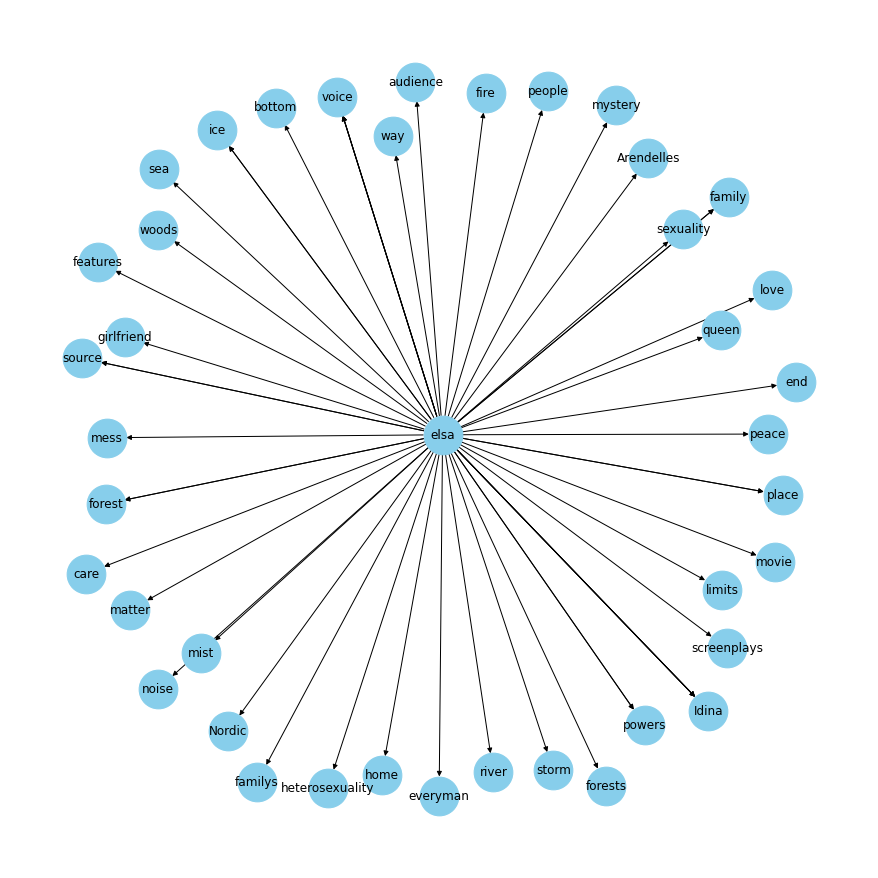

In [295]:
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k= 0.5)

nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos, node_size = 1500
        )
#nx.draw_networkx_edge_labels(G, pos, edge_labels= edge_label)

plt.show()

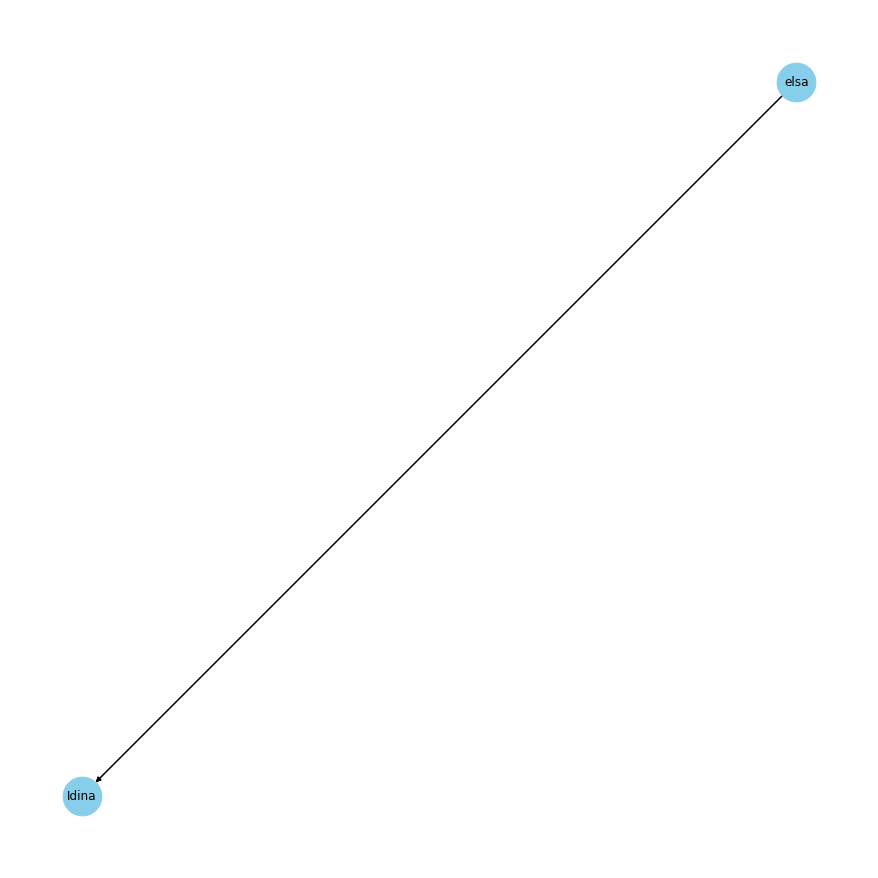

In [300]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="voiced"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.1) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
nx.edges(G)
plt.show()